<a href="https://colab.research.google.com/github/CoolCodeMan/intro2LT/blob/lauri/pytorch-final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
import warnings
warnings.filterwarnings('ignore')

# Download data

In [23]:
!wget -q -O anger-train.tsv http://dl.turkunlp.org/TKO_8966_2021-projects/anger-annotation/train.tsv
!wget -q -O anger-test.tsv http://dl.turkunlp.org/TKO_8966_2021-projects/anger-annotation/test.tsv
!wget -q -O anger-dev.tsv http://dl.turkunlp.org/TKO_8966_2021-projects/anger-annotation/dev.tsv

!wget -q -O joy-train.tsv http://dl.turkunlp.org/TKO_8966_2021-projects/joy-annotation/train.tsv
!wget -q -O joy-test.tsv http://dl.turkunlp.org/TKO_8966_2021-projects/joy-annotation/test.tsv
!wget -q -O joy-dev.tsv http://dl.turkunlp.org/TKO_8966_2021-projects/joy-annotation/dev.tsv

# import python libraries

- numpy
- pandas
- pytorch
- scikit
- matplotlib

In [24]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as functional
import torch.optim as optim
from scipy.sparse import *
import sklearn.utils
import matplotlib.pyplot as plt

# Set up functions

- **shuffle** shuffles pandas dataframe
- **make_labels** takes in pandas dataframe and transforms it into tensor
- **create_dataset** takes anger and joy files, opens them into pandas dataframe and changing labels not-joy and not-anger into neutral
- **create_dataset_and_testset** takes in pandas dataframes and tranforms them into pytorch tensor
- **score** takes in model and tensors, scoring them
- **torch_shuffle** -- incomplete

In [25]:
def shuffle(data):
  data = sklearn.utils.shuffle(data)
  data.reset_index(inplace=True, drop=True)
  return data

In [26]:
def make_labels(labels):
  y = []
  for i in labels:
    if i == 'joy':
      y.append([1,0,0])
    elif i == 'anger':
      y.append([0,1,0])
    elif i == 'neutral':
      y.append([0,0,1])
  y = torch.tensor(y).float()
  return y

In [27]:
def create_dataset(angerpath, joypath):
  anger = pd.read_csv(angerpath, error_bad_lines=False, header=0, names=['emotion','text'], sep='\t')
  joy= pd.read_csv(joypath, error_bad_lines=False, header=0, names=['emotion','text'], sep='\t')

  df = pd.concat([joy, anger])
  df['emotion'].replace({'not-joy':'neutral', 'not-anger':'neutral'}, inplace=True)
  df = shuffle(df)

  return df

In [28]:
def create_dataset_and_testset(pandas_dataset, vectorizer):

  feature_matrix = vectorizer.transform(pandas_dataset['text'])
  mat = feature_matrix.astype('float').toarray()
  X = torch.from_numpy(mat)
  y = make_labels(pandas_dataset['emotion'])

  return X, y

In [29]:
def score(model, dataset, labels, dataset_size=2024):
  total = 0
  for i in range(dataset_size):
    pred = model(dataset[i].float())
    n1 = pred.detach().cpu().numpy().argmax()
    n2 = labels[i].detach().cpu().numpy().argmax()
    if n2 == n1:
      total += 1
    
  return total/dataset_size*100

In [30]:
def torch_shuffle(df, vectorizer):
  df = shuffle(df)
  X, y = create_dataset_and_testset(df, vectorizer)
  return X, y

# Initialize data

In [31]:
dataset = create_dataset('/content/anger-train.tsv', '/content/joy-train.tsv')
vectorizer=CountVectorizer(analyzer='word', ngram_range=(1,1))
vectorizer.fit(dataset['text'])
dataset_train, labels_train = create_dataset_and_testset(dataset, vectorizer)

In [32]:
dataframe_dev = create_dataset('/content/anger-dev.tsv', '/content/joy-dev.tsv')
dataset_dev, labels_dev = create_dataset_and_testset(dataframe_dev, vectorizer)

In [33]:
dataframe_test = create_dataset('/content/anger-test.tsv', '/content/joy-test.tsv')
dataset_test, labels_test = create_dataset_and_testset(dataframe_test, vectorizer)

# Setup pytorch device

In [34]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [35]:
dataset_train = dataset_train.to(device)
labels_train = labels_train.to(device)

dataset_dev = dataset_dev.to(device)
labels_dev = labels_dev.to(device)

dataset_test = dataset_test.to(device)
labels_test = labels_test.to(device)

# Init neural network

In [36]:
class Net(nn.Module):
  def __init__(self, size):
    super(Net, self).__init__()

    self.fc1 = nn.Linear(size, 100)
    self.fc2 = nn.Linear(100, 3)

  def forward(self, X):

    out = self.fc1(X)
    out = torch.relu(out)

    out = self.fc2(out)

    return out

# Setup neural network, loss function and optimizer

In [39]:
vocab_size = dataset_train.shape[1]
model = Net(vocab_size)

loss_function = nn.L1Loss()
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.4)

accuracy = []
losses = []

model = model.to(device)
loss_function = loss_function.to(device)

# Train model

In [40]:
running_loss = 0.0
for epoch in range(50):
  print('epoch ', epoch, ' loss ', round(running_loss,3))
  running_loss = 0.0

  for i in range(2025):    
    optimizer.zero_grad()

    out = model(dataset_train[i].float())
    loss = loss_function(out, labels_train[i])
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    if i % 100 == 99:
        accuracy.append(score(model, dataset_train[:50], labels_train[:50], 50))
        losses.append(running_loss/100)
        running_loss = 0.0

epoch  0  loss  0.0
epoch  1  loss  5.432
epoch  2  loss  5.366
epoch  3  loss  5.321
epoch  4  loss  5.29
epoch  5  loss  5.24
epoch  6  loss  5.145
epoch  7  loss  5.042
epoch  8  loss  4.87
epoch  9  loss  4.785
epoch  10  loss  4.447
epoch  11  loss  4.131
epoch  12  loss  3.888
epoch  13  loss  3.419
epoch  14  loss  3.481
epoch  15  loss  2.974
epoch  16  loss  2.984
epoch  17  loss  2.633
epoch  18  loss  2.84
epoch  19  loss  2.467
epoch  20  loss  2.724
epoch  21  loss  2.475
epoch  22  loss  2.423
epoch  23  loss  2.146
epoch  24  loss  2.135
epoch  25  loss  2.279
epoch  26  loss  2.161
epoch  27  loss  2.115
epoch  28  loss  2.235
epoch  29  loss  1.876
epoch  30  loss  1.923
epoch  31  loss  1.981
epoch  32  loss  1.794
epoch  33  loss  1.727
epoch  34  loss  1.459
epoch  35  loss  1.889
epoch  36  loss  1.605
epoch  37  loss  1.6
epoch  38  loss  1.642
epoch  39  loss  1.682
epoch  40  loss  1.547
epoch  41  loss  1.54
epoch  42  loss  1.494
epoch  43  loss  1.566
epoch  

# SCORES

In [41]:
print('Train ', round(score(model, dataset_train, labels_train, dataset_size=2025), 3))
print('Devel ', round(score(model, dataset_dev, labels_dev, dataframe_dev.shape[0]), 3))
print('Test ', round(score(model, dataset_test, labels_test, dataframe_test.shape[0]), 3))

Train  99.259
Devel  80.333
Test  80.912


# Statistics

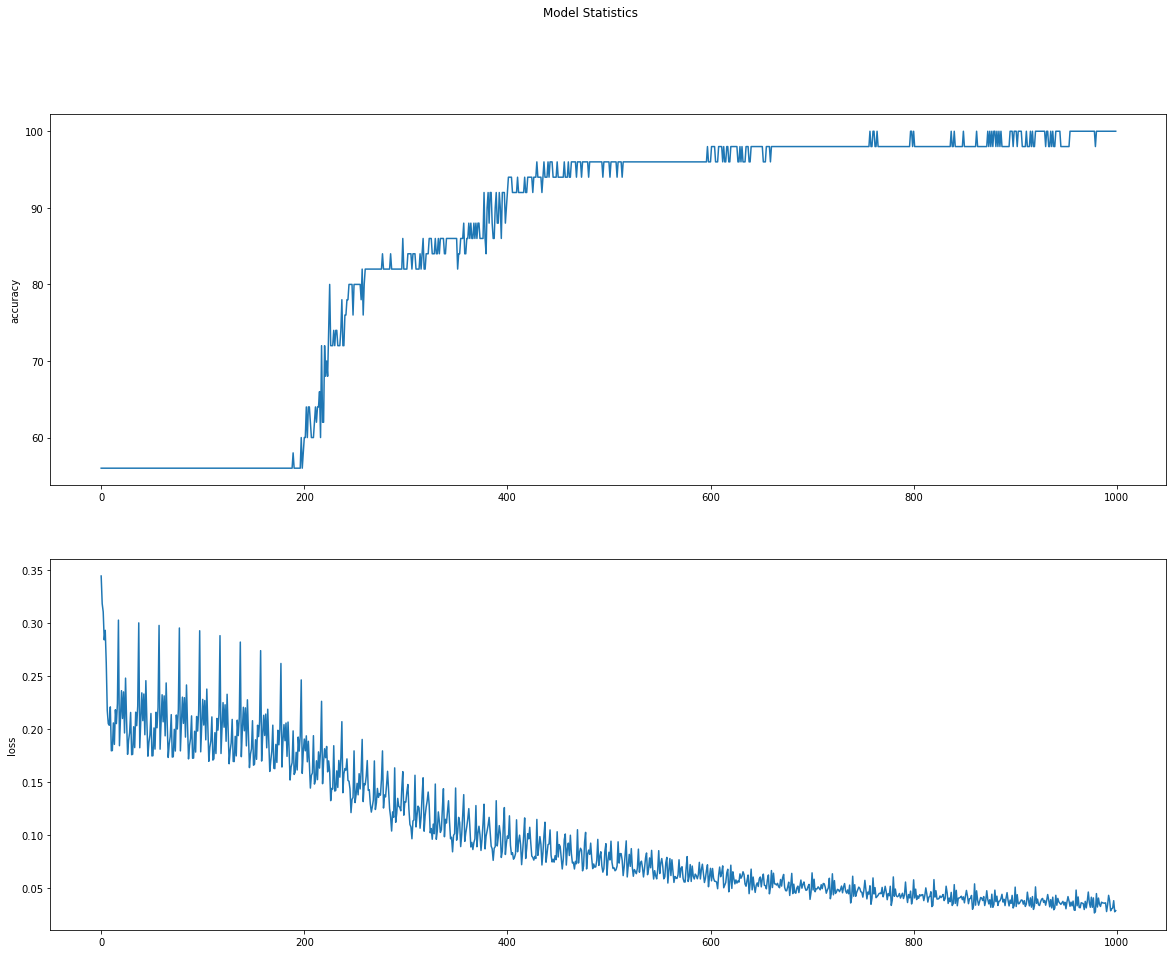

In [42]:
%matplotlib inline

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,15))

fig.suptitle('Model Statistics')

ax1.plot(accuracy)
ax1.set_ylabel('accuracy')

ax2.plot(losses)
ax2.set_ylabel('loss')

plt.show()